In [1]:
import ipywidgets as widgets
from IPython.display import display
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import numpy as np
import scipy
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Text(0, 0.5, 'ypix')

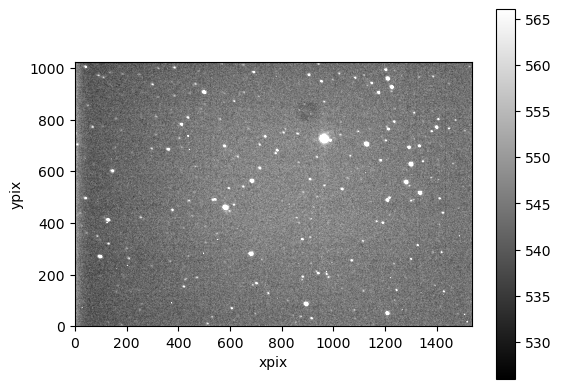

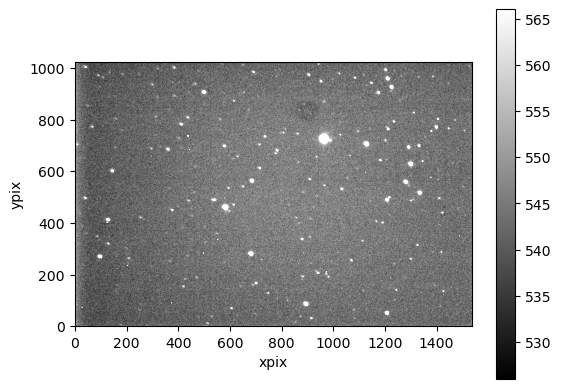

In [2]:
dir_path = '/home/machado/Desktop/Universidade/5 ano 1 semestre/LabAstro/data/20230919/'

file1 =  dir_path + 'hd-189733_2023-09-20_00-35-55_black_1980.fits'
file2 =  dir_path + 'hd-189733_2023-09-20_00-36-00_black_1981.fits'

#fits1 = fits.open(file1)
fits1, fits2 = fits.open(file1), fits.open(file2)

#head1 = fits1[0].header
#data1 = fits1[0].data
head1, head2 = fits1[0].header, fits2[0].header
data1, data2 = fits1[0].data, fits2[0].data

lo,up = np.percentile(data1, 1), np.percentile(data1, 99)
plt.figure()
plt.imshow(data1, cmap='gray', origin='lower', clim=(lo, up))
plt.colorbar()
plt.xlabel('xpix')
plt.ylabel('ypix')
plt.figure()
plt.imshow(data2, cmap='gray', origin='lower', clim=(lo, up))
plt.colorbar()
plt.xlabel('xpix')
plt.ylabel('ypix')

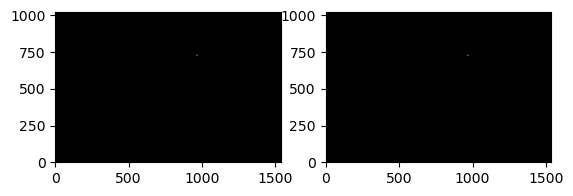

In [3]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(data1/np.median(data1),cmap='gray',origin='lower')
ax[1].imshow(data2/np.median(data2),cmap='gray',origin='lower')

In [4]:
allflat = np.asarray([data1/np.median(data1),data2/np.median(data2)])
np.shape(allflat)

(2, 1024, 1536)

In [5]:
medianflat,meanflat = np.median(allflat,axis=0),np.mean(allflat,axis=0)

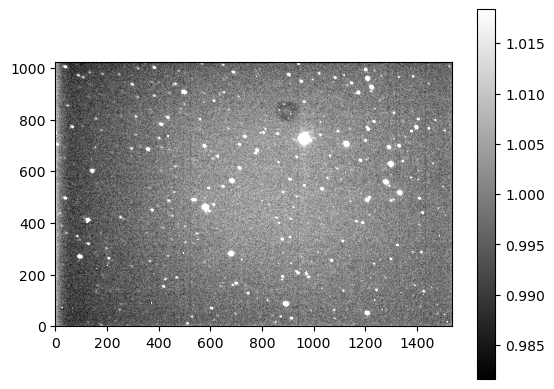

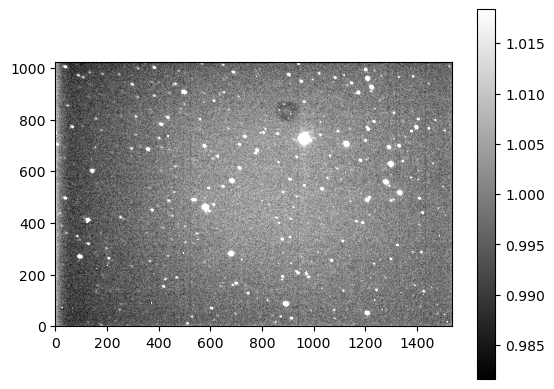

In [6]:
lo,up = np.percentile(medianflat,5),np.percentile(medianflat,95)
plt.figure()
plt.imshow(medianflat,cmap='gray',clim=(lo,up),origin='lower')
plt.colorbar()
lo,up = np.percentile(meanflat,5),np.percentile(meanflat,95)
plt.figure()
plt.imshow(meanflat,cmap='gray',clim=(lo,up),origin='lower')
plt.colorbar()

Output()

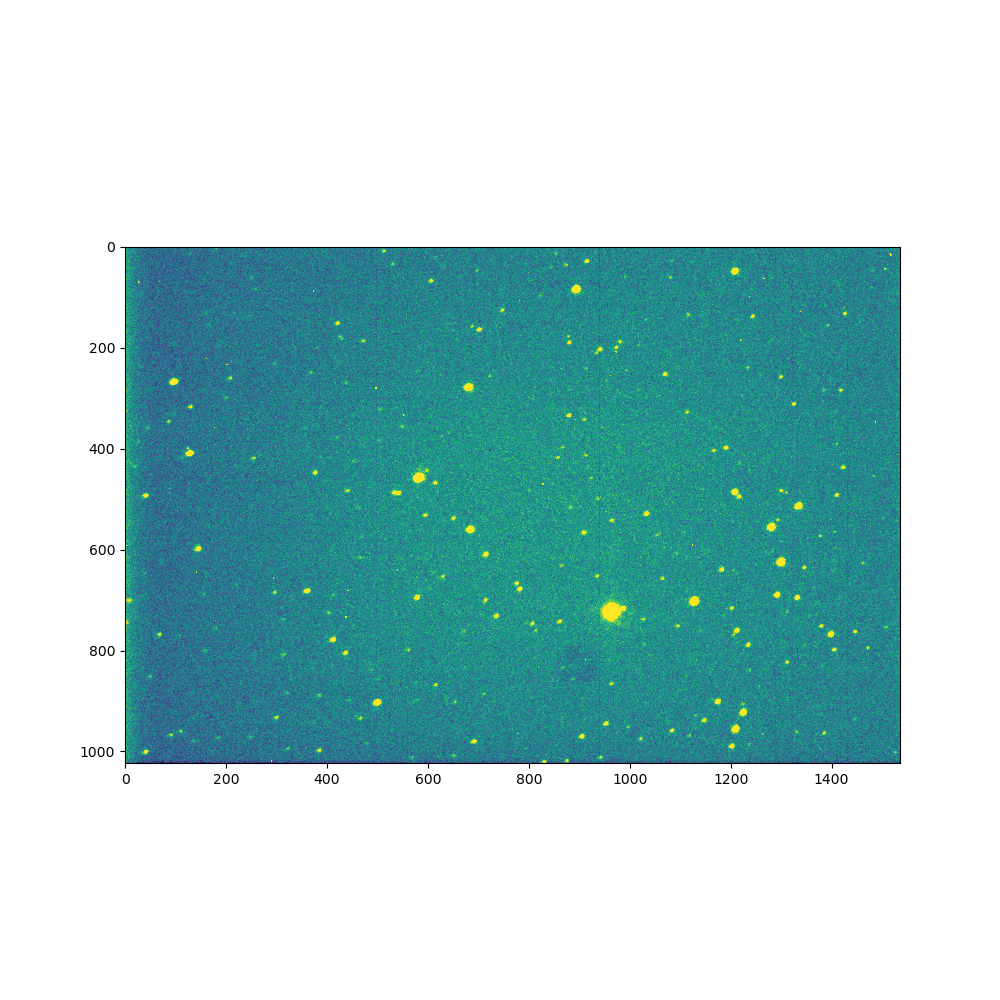

In [15]:
##Obtain positions interactively
%matplotlib widget

#this will print out the stars we click
output = widgets.Output()
display(output)

## --- These are auxiliary functions

def on_click(event):
    with output:
        global stars1
        print('     star1=%i: x=%d, y=%d, xdata=%f, ydata=%f'%(
            len(stars1)+1, event.x, event.y, event.xdata, event.ydata))
        stars1.append((np.round(event.xdata), np.round(event.ydata)))
    return stars1

global stars1,fig1,cid1
stars1 = []
fig1 = plt.figure(1,figsize=(10,10))
ax1 = fig1.add_subplot(111)
lo,up = np.percentile(data1, 1),np.percentile(data1, 99)
ax1.imshow(data1,clim=(lo,up))
cid1 = fig1.canvas.mpl_connect('button_press_event', on_click)
plt.show()

In [18]:
plt.close()
pos1 = [965, 734]
pos2 = [958, 719]

[964.65382878 722.73438312] [963.63038377 722.93546105]
[964.40182516 729.19128485] [959.85740558 720.39495991]


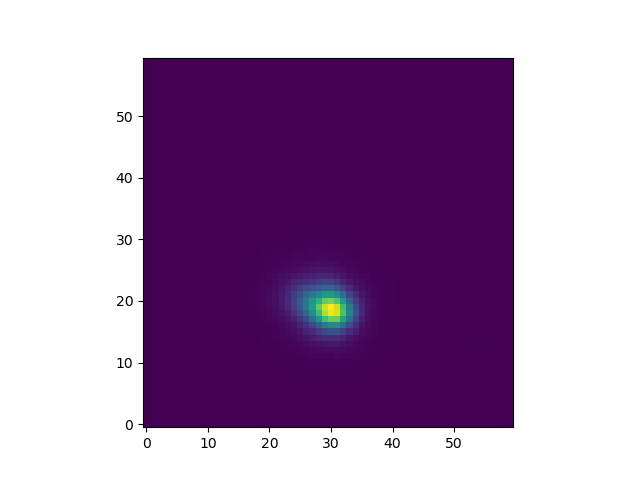

In [19]:
from photutils.centroids import centroid_2dg, centroid_com  #load centroid libraries
subdata1 = data1[pos1[1]-30:pos1[1]+30,pos1[0]-30:pos1[0]+30]#select subportion of 60x60 image
subdata2 = data2[pos2[1]-30:pos2[1]+30,pos2[0]-30:pos2[0]+30]#select subportion of 60x60 image
plt.imshow(subdata1,origin='lower')
center1,center2 = centroid_2dg(subdata1)+pos1-[30,30],centroid_2dg(subdata2)+pos2-[30,30]
ccenter1,ccenter2 = centroid_com(subdata1)+pos1-[30,30],centroid_com(subdata2)+pos2-[30,30]
print(center1,center2)
print(ccenter1,ccenter2)

In [21]:
## Shift image
shiftdat = np.roll(data2,-int(np.round(center2[1]-center1[1])),axis=0) #shift in y
shiftdata2 = np.roll(shiftdat,-int(np.round(center2[0]-center1[0])),axis=1) #shift in x

In [22]:
## Save image (in the Google drive)
head2['PROCESS'] = 'shifted'
fits.writeto('test.fits',shiftdata2,head2,overwrite=True)

Text(0, 0.5, 'ypix')

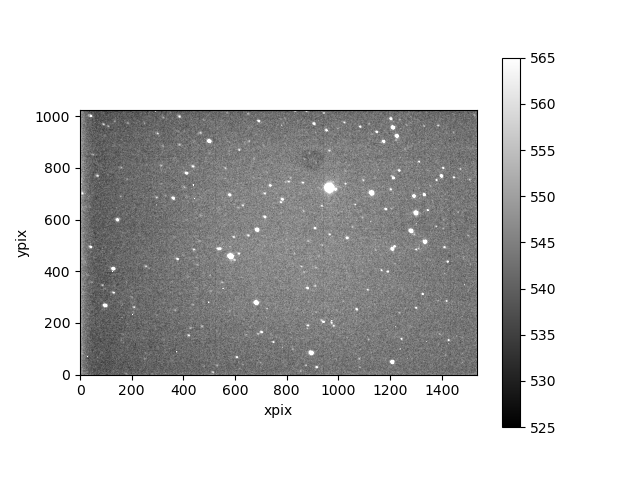

In [26]:
filep3 = '/home/machado/Desktop/Universidade/5 ano 1 semestre/LabAstro/data/test.fits'

file3 = fits.open(filep3)

data3 = file3[0].data

lo,up = np.percentile(data3, 1), np.percentile(data3, 99)
plt.figure()
plt.imshow(data3, cmap='gray', origin='lower', clim=(lo, up))
plt.colorbar()
plt.xlabel('xpix')
plt.ylabel('ypix')

In [ ]:
#FWHM by fitting 2d Gaussian to stars

In [27]:
fitsfile = fits.open(filep3)
head1,data1 = fitsfile[0].header,fitsfile[0].data

In [28]:
## Find stars in the field
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats,gaussian_sigma_to_fwhm

## Get background
mean, median, std = sigma_clipped_stats(data1,sigma=3.0,maxiters=5)
## Find stars
daofind = DAOStarFinder(fwhm=10.0, threshold=4.0*std)  ##peakmax to exclude saturated stars!!
sources = daofind(data1 - median)
print("     Found %i stars in image " %len(sources))

/tmp/ipykernel_40604/1195806184.py:2: DeprecationWarning: `photutils.DAOStarFinder` is a deprecated alias for `photutils.detection.DAOStarFinder` and will be removed in the future. Instead, please use `from photutils.detection import DAOStarFinder` to silence this warning.
  from photutils import DAOStarFinder


     Found 182 stars in image 


Text(0, 0.5, 'y (pix)')

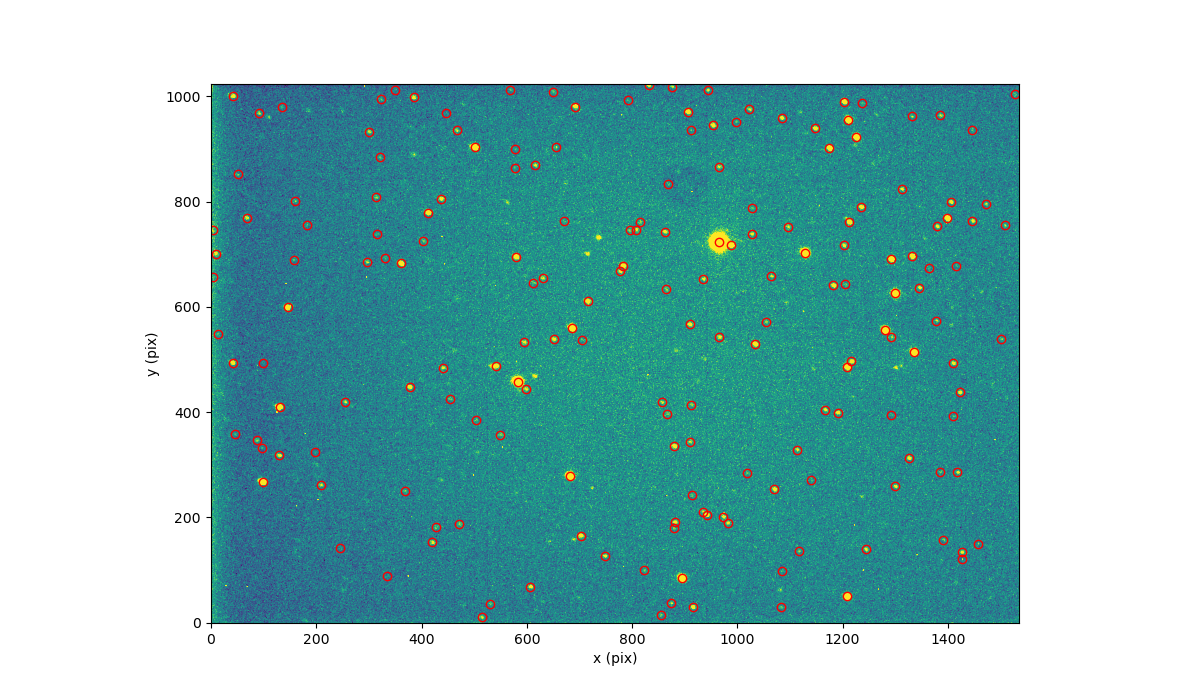

In [29]:
## Plot stars found
fig = plt.figure(figsize=(12,7))
l1 = np.percentile(data1[np.isfinite(data1)].flatten(), 1)
l2 = np.percentile(data1[np.isfinite(data1)].flatten(), 99)
plt.imshow(data1,clim=(l1,l2),origin='lower')
plt.plot(sources["xcentroid"],sources["ycentroid"],'or',mfc='none')
plt.xlabel("x (pix)")
plt.ylabel("y (pix)")

In [31]:
## Take nbright brightest stars and print list
nbright = 5
brightest = np.argsort(sources['flux'])[::-1][0:nbright]
brsources = sources[brightest]
print(brsources)

 id     xcentroid      ...        flux               mag        
--- ------------------ ... ------------------ ------------------
115  964.6808706121477 ... 2344.4357483210347 -8.425095837374743
 66  583.5821483439416 ...   174.409996371703 -5.603928432636063
112 1128.6398340655612 ... 140.37606544386298 -5.368232663861844
 90  1300.099834562942 ... 120.51017658036486  -5.20255930702996
  9  895.0548752836785 ...  84.98792596213677 -4.823393077212792


In [32]:
## Fit the Gaussian PSF to brightest stars
rmax = 25
(ny,nx) = np.shape(data1)
from astropy.modeling import models,fitting
fit_g = fitting.LevMarLSQFitter()
allxfwhm, allyfwhm = np.zeros(len(brsources)),np.zeros(len(brsources))
allfwhm,alltheta = np.zeros(len(brsources)),np.zeros(len(brsources))
for i,src in enumerate(brsources):
  if int(src['ycentroid']) > rmax and int(src['ycentroid']) < ny-rmax and \
     int(src['xcentroid']) > rmax and int(src['xcentroid']) < nx-rmax:
    img = data1[int(src['ycentroid'])-rmax:int(src['ycentroid'])+rmax,
                int(src['xcentroid'])-rmax:int(src['xcentroid'])+rmax]
    subx,suby = np.indices(img.shape) # instead of meshgrid
    p_init = models.Gaussian2D(amplitude=np.max(img),x_mean=rmax,y_mean=rmax,x_stddev=1.0,y_stddev=1.0)
    fitgauss = fit_g(p_init, subx, suby, img - np.min(img))
    allxfwhm[i] = np.abs(fitgauss.x_stddev.value)
    allyfwhm[i] = np.abs(fitgauss.y_stddev.value)
    allfwhm[i] = 0.5*(allxfwhm[i]+allyfwhm[i])
    alltheta[i] = fitgauss.theta.value
xfwhm,yfwhm = np.median(allxfwhm)*gaussian_sigma_to_fwhm,np.median(allyfwhm)*gaussian_sigma_to_fwhm
fwhm = np.median(allfwhm)*gaussian_sigma_to_fwhm
sigfwhm, sigxfwhm, sigyfwhm = np.std(allfwhm), np.std(allxfwhm), np.std(allyfwhm)
medtheta = np.median(alltheta)
print("     x-FWHM %f +/- %f (pix) for this image " %(xfwhm,sigxfwhm))
print("     y-FWHM %f +/- %f (pix) for this image " %(yfwhm,sigyfwhm))
print("     FWHM %f +/- %f (pix) for this image " %(fwhm,sigfwhm))

     x-FWHM 5.362281 +/- 0.306657 (pix) for this image 
     y-FWHM 6.646618 +/- 0.379384 (pix) for this image 
     FWHM 6.130369 +/- 0.205166 (pix) for this image 


IndexError: Missing parameter or input

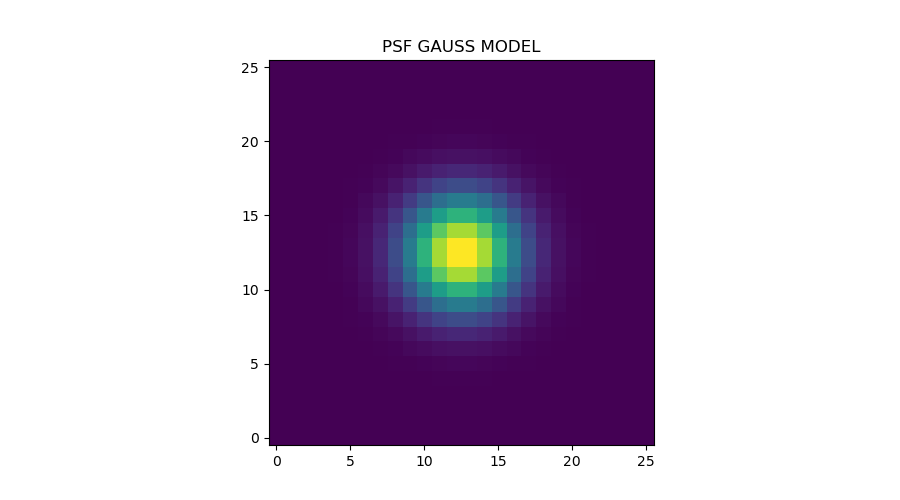

In [57]:
## Generate PSF from FWHM
from photutils.psf import prepare_psf_model,extract_stars,EPSFBuilder,IntegratedGaussianPRF
psf = IntegratedGaussianPRF(sigma=fwhm/gaussian_sigma_to_fwhm)  ## 1D Gauss
two2dgauss = models.Gaussian2D(x_mean=0.0,y_mean=0.0,theta=medtheta,x_stddev=xfwhm/gaussian_sigma_to_fwhm,y_stddev=yfwhm/gaussian_sigma_to_fwhm)
two2dpsf = prepare_psf_model(two2dgauss)
#two2dpsf = prepare_psf_model(two2dgauss,xname='x_mean',yname='y_mean',fluxname='amplitude')
## plot
xx,yy =  np.meshgrid(np.arange(rmax+1)-rmax/2,np.arange(rmax+1)-rmax/2)
impsf = psf.evaluate(xx,yy,*psf.parameters)
fig,ax = plt.subplots(1,1,figsize=(9,5))
ax.imshow(impsf,origin='lower')
ax.set_title('PSF GAUSS MODEL')
impsf = two2dpsf.evaluate(xx,yy,x_mean=0.0, y_mean=0.0, amplitude=1.0)
#impsf = two2dpsf.evaluate(xx,yy)
fig,ax = plt.subplots(1,1,figsize=(9,5))
ax.imshow(impsf,origin='lower')
ax.set_title('PSF 2D GAUSS MODEL')